# TCN-And-RevIN
- **Import Some Packages**: 导入一些必要的包
- **Set Functions and Params**: 设置一些必要的函数：随机种子、选择gpu
- **Data Process**: 数据收集，格式转换，数据预处理（数据清洗：处理缺失值。
  异常值数据转换：如对数转换，归一化等，以稳定数据的方差(此处应该是两部分包括异常之检测和异常值处理)）
- **Data Analysis**: 数据分析：分析数据的特征，如季节性、趋势、周期性等，这一步是重要的你的模型的效果好坏可能百分之60来源于模型，另外的百分之40就来源于这一步

- **Set Dataset**: 划分数据集，设置dataset，设置dataloader
- **Set DataLoader**
- **Set Model**：选择模型
- **train/dev/test**: 编写训练/验证/测试函数
- **Start train**
- **Start predict**
- **Plot**
- **Model evaluation**

** Note ** 加上了RevIN

## Import Some Packages

In [199]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn.utils import weight_norm

# For txt
import sys
time_stand = 2024250000000.000

# For data preprocess
import numpy as np
import csv
import os
from sklearn.preprocessing import MinMaxScaler
import math

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
# Non-interactive backend, you can't call plt.show() to see the figure interactively
# matplotlib.use('Agg') must be placed before import matplotlib.pyplot
# matplotlib.use('Agg') 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pandas as pd

## Set Functions and Params

In [200]:
# hyperparameter
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 300,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-4,                 # learning rate
        # 'momentum': 0.9              # momentum
        'weight_decay': 1e-5        # weight_decay
    },
    'model':{
        'kernel_sizes':3,
        'model_dim':[64, 128, 256],#这个地方是这个TCN卷积的关键部分,它代表了TCN的层数我这里输入list中包含三个元素那么我的TCN就是三层，这个根据你的数据复杂度来设置层数越多对应数据越复杂但是不要超过5层

    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth' , # your model will be saved here
    'fig_path': 'fig/',
    'fig_type': 'png',
    'window_len':100*2,                   # T = 100
    'window_step':1,
    'pre_len':20, 
    'future':20*5,
    'seed':5201314,
    'valid_ratio': 0.3
}
myseed = config['seed']
# Set Random Seed
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
same_seed(myseed)

def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
# 归一化处理
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
 
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)
 
    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std
 
    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        # if data.shape[-1] != mean.shape[-1]:
        #     mean = mean[-1:]
        #     std = std[-1:]
        return (data * std) + mean
    


# 绘制Loss图像
def plot_loss_data(data):
    # 使用Matplotlib绘制线图
    plt.figure()
 
    plt.plot(data, marker='o')
 
    # 添加标题
    plt.title("loss results Plot")
 
    # 显示图例
    plt.legend(["Loss"])
 
    plt.show()

## RevIN

In [201]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: 特征或通道的数量
        :param eps: 数值稳定性参数，防止除零错误
        :param affine: 如果为True，RevIN有可学习的仿射参数
        :param subtract_last: 如果为True，减去最后一个时间步的值
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    # def forward(self, x, mode: str, mask=None):
    #     if mode == 'norm':
    #         self._get_statistics(x, mask)
    #         x = self._normalize(x)
    #     elif mode == 'denorm':
    #         x = self._denormalize(x)
    #     else:
    #         raise NotImplementedError
    #     return x
    def forward(self, x, mode: str, mask=None):
        if mode == 'norm':
            self._get_statistics(x, mask)
            x = x.clone()  # Clone to prevent modifying original input
            x = self._normalize(x)
        elif mode == 'denorm':
            x = x.clone()  # Keep original input intact
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x
    def _init_params(self):
        # 初始化RevIN参数: (M,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    # def _get_statistics(self, x, mask=None):
    #     dim2reduce = tuple(range(1, x.ndim - 1))
    #     if self.subtract_last:
    #         self.last = x[:, -1, :].unsqueeze(1)
    #     else:
    #         self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
    #     self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()
        # 这两行代码中的 detach() 方法是为了从计算图中分离这些统计量，防止它们在后续的前向传播中被追溯到。如果没有 detach()，self.mean 和 self.stdev 就会保留在计算图中，导致在反向传播时出现错误。
    def _get_statistics(self, x, mask=None):
        print("Calculating statistics...")
        dim2reduce = tuple(range(1, x.ndim - 1))
        
        if self.subtract_last:
            self.last = x[:, -1, :].detach()
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
            self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

        print("Mean:", self.mean)
        print("Stdev:", self.stdev)

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


## Data Process

In [202]:
# 导入数据
path_SL = 'Data/statlink01_orbit.txt'
path_Lunar = 'Data/Lunar_Vector_J2000.txt'
path_Sun = 'Data/Sun_Vector_J2000.txt'

def datacatcher(path,idx_start,idx_end,line_pass):
    f = open(path , encoding='utf-8')
    line = f.readline()
    list = []
    count = 0
    while line:
        if(count%line_pass == 0):
            a = line.split(" ")            #将数据以空格的方式分隔开
            b = a[idx_start:idx_end]              #这就是选择前四行保存下来（如果想保存第2，3行就写成b = a[1,3]）即可
            list.append(b)
            # list.append('\n')
        line = f.readline()
        count = count+1
    f.close()
    data_array=np.array(list)
    return data_array.astype(float)
data_SL_raw = datacatcher(path_SL,0,4,4)
data_Lunar = datacatcher(path_Lunar,4,7,1)
data_Sun = datacatcher(path_Sun,4,7,1)
data_time = data_SL_raw[:,:1]-time_stand
data_SL = data_SL_raw[:,1:]# 除去时间特征
slide_step = 1
# Dataset_raw = np.hstack((data_time, data_Sun,data_Lunar, data_SL))#
Dataset_raw = np.hstack((data_SL[:-1*slide_step,:],data_SL[1*slide_step:,:]))#
Dataset_raw = Dataset_raw[:,0]
print(type(Dataset_raw))
print(Dataset_raw.shape)
print(Dataset_raw.ndim)

# 异常值处理
def OutlierProcessing(data):
    # print("原始数据:", data)
    # 处理数据中的Nan值
    window_size = 5
    threshold = 3
    moving_avg = np.empty_like(data)
    # 使用 np.nanmean 计算滚动平均
    for i in range(len(data)):
        if i < window_size:
            moving_avg[i] = np.nanmean(data[:i + 1])
        else:
            moving_avg[i] = np.nanmean(data[i - window_size + 1:i + 1])
    # 替换原始数据中的 NaN 值为对应的移动平均值
    data[np.isnan(data)] = moving_avg[np.isnan(data)]  # 或者 data = np.where(np.isnan(data), moving_avg, data)
    # 计算 Z-score
    mean = np.nanmean(data)
    std_dev = np.nanstd(data)
    z_scores = (data - mean) / std_dev
    # 检测异常值
    outliers = np.abs(z_scores) > threshold

    # 使用移动平均值替换异常值
    data[outliers] = moving_avg[outliers] # 会提取 data 数组中所有被标记为异常值的位置，得到的是异常值对应的数据。

    # 输出结果

    # print("移动平均:", moving_avg)
    # print("Z-score:", z_scores)
    # print("异常值的掩码:", outliers)
    # print("替换后的数据:", data)
    return data
Dataset_raw = OutlierProcessing(Dataset_raw)


<class 'numpy.ndarray'>
(4320,)
1


## Data Analysis 

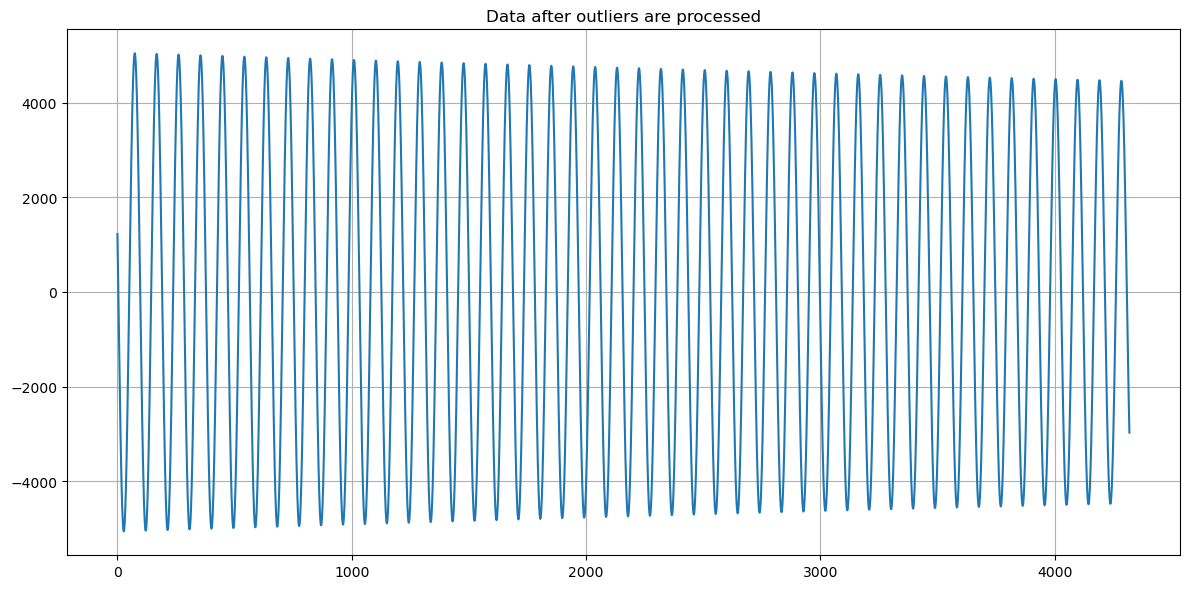

T=655
ADF 统计量: -33.5344
p 值: 0.0000
临界值:
	 1%: -3.432
	 5%: -2.862
	 10%: -2.567
拒绝原假设：时间序列是平稳的


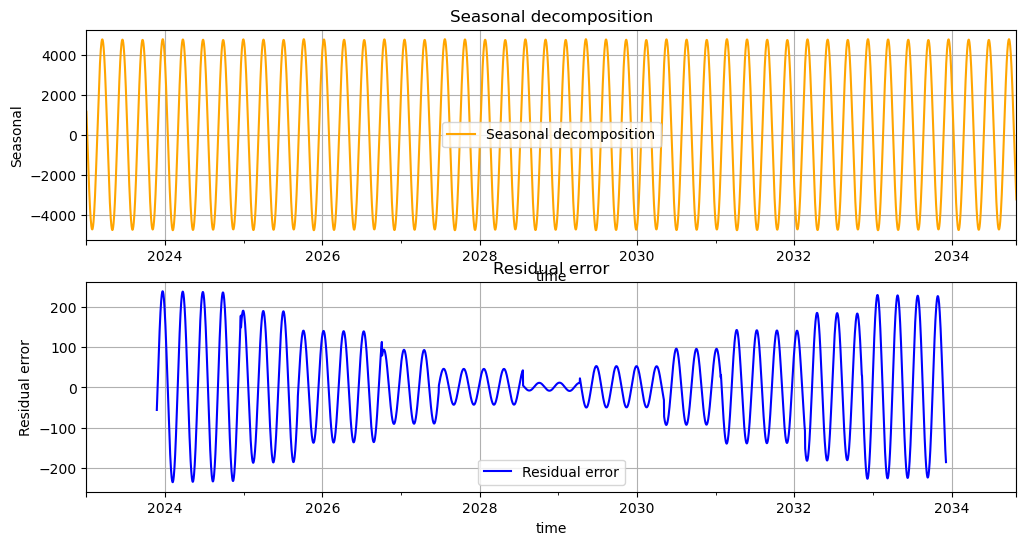

In [203]:
# 使用 Pandas 创建时间序列
dates = pd.date_range(start='2023-01-01', periods=len(Dataset_raw), freq='D')  # 生成对应日期
series = pd.Series(Dataset_raw, index=dates)
# 绘制数据图像大体观察一下
plt.figure(figsize=(12, 6))
plt.plot(Dataset_raw)
plt.title('Data after outliers are processed')
plt.grid()
plt.tight_layout()
plt.show()
# 估计周期（简单方法，通过估计自相关）
def estimate_period(data):
    lag = 1
    autocorr = []
    
    while lag < len(data) // 2:
        corr = np.corrcoef(data[:-lag], data[lag:])[0, 1]  # 计算自相关
        autocorr.append(corr)
        lag += 1
    
    return np.argmax(autocorr) + 1  # 返回自相关最大的滞后值（周期）

estimated_period = estimate_period(series)  # 仅使用有效数据
print(f'T={estimated_period }')
# 进行季节性分解
decomposition = seasonal_decompose(series, model='additive', period=estimated_period)
plt.figure(figsize=(12, 6))
# 季节性分析图
plt.subplot(2, 1, 1)  # 三行一列的第二个子图
decomposition.seasonal.plot(ax=plt.gca(), label='Seasonal decomposition', color='orange')
plt.title('Seasonal decomposition')
plt.xlabel('time')
plt.ylabel('Seasonal')
plt.legend()
plt.grid()

# 残差图
plt.subplot(2, 1, 2)  # 三行一列的第三个子图
decomposition.resid.plot(ax=plt.gca(), label='Residual error', color='blue')
plt.title('Residual error')
plt.xlabel('time')
plt.ylabel('Residual error')
plt.legend()
plt.grid()

# 平稳性检验
# ADF 检验
adf_result = adfuller(series.dropna())  # 清除 NaN 值进行检验
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# 打印 ADF 检验结果
print('ADF 统计量: {:.4f}'.format(adf_statistic))
print('p 值: {:.4f}'.format(p_value))
print('临界值:')
for key in critical_values.keys():  # 结果中的每个关键字都是单独的
    print('\t {}: {:.3f}'.format(key, critical_values[key]))

# 检验结论
if p_value < 0.05:
    print('拒绝原假设：时间序列是平稳的')
else:
    print('不能拒绝原假设：时间序列具有单位根，非平稳')

## Set Dataset

In [204]:
# 数据集划分
def train_valid_split(data_set,valid_ratio,seed):
    test_data = data_set[3200:]   # 1320
    train_data = data_set[:2600] # 2600
    valid_data = data_set[2600:3200] # 600
    print(f'size of test_data is {test_data.shape}')
    print(f'size of train_data is {train_data.shape}')
    print(f'size of valid_data is {valid_data.shape}')
    return np.array(train_data).astype(float),np.array(valid_data).astype(float),np.array(test_data).astype(float)
# 构造数据集
class TimeSeriesDataset(Dataset):
    # input:数据路径；模式（默认为train）；特征选择
    def __init__(self,
                 data,
                 label,
                 mode='train'):
        # Determine the mode
        self.mode = mode
        # 检查数据类型
        # data = np.array(data)  # Convert to numpy array if not already
        # label = np.array(label)
        # print(data.dtype)  # 查看数据类型
        if mode == 'test':
            self.data = torch.FloatTensor(np.array(data))[:, :, None]# 转化成张量
        else:            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(np.array(data))[:, :, None]
            self.label = torch.FloatTensor(np.array(label))[:, :, None]
        self.dim = 1# 选取的是第二维度
        print('Finished reading the {} set of Orbit Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.label[index]
        else:
            # For testing (no label)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
# 数据分割器
def create_inout_sequences(input_data, tw, pre_len, config):
    '''
    创建时间序列数据专用的数据分割器
    input_data: 输入的时间序列数据，通常是一个数组或矩阵。
    tw: 滑动窗口大小，决定了每个输入序列的长度。
    pre_len: 预测长度，即模型需要预测的未来数据点的数量。
    config: 配置对象，包含有关特征选择的信息。
    '''
    inout_seq_data = []       # 初始化：创建一个空列表 inout_seq 用于存储输入输出序列对
    inout_seq_label = []       # 初始化：创建一个空列表 inout_seq 用于存储输入输出序列对

    L = len(input_data)
    for i in range(L - tw):
        
        if (i + tw + pre_len) < len(input_data):
            seq_data = input_data[i:i + tw] # 在每个迭代中，提取当前的输入序列 train_seq，长度为 tw
            seq_label = input_data[i + tw:i + tw + pre_len]
            inout_seq_data.append(seq_data)
            inout_seq_label.append(seq_label)
    return inout_seq_data,inout_seq_label

## Set DataLoader

In [205]:
def create_dataloader(data, config, device):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    # 设计超参数
    pre_len = config['pre_len']  # 预测未来数据的长度
    train_window = config['window_len']  # 观测窗口

    # 定义标准化优化器
    # scaler = StandardScaler()
    # scaler.fit(data)
    # 创建RevIN模块
    scaler = RevIN(num_features=1, affine=True, subtract_last=False)

    
    # 划分数据
    train_data,valid_data,test_data = train_valid_split(data,config['valid_ratio'],config['seed'])

 
    # # 进行标准化处理
    # train_data_normalized = scaler.transform(train_data)
    # valid_data_normalized = scaler.transform(valid_data)
    # test_data_normalized = scaler.transform(test_data)
    # print(f'train_data_normalized  is {train_data_normalized.shape}')
    # print(f'valid_data_normalized is {valid_data_normalized.shape}')
    # print(f'test_data_normalized is {test_data_normalized.shape}')    



    # 定义训练器的的输入
    train_data,train_label = create_inout_sequences(train_data, train_window, pre_len, config)
    valid_data,valid_label = create_inout_sequences(valid_data, train_window, pre_len, config)
    test_data,test_label  = create_inout_sequences(test_data,  train_window, pre_len, config)
    # print(f'{test_inout_seq} ' )
    # print(f'{train_inout_seq} ')
    # print(f'{valid_inout_seq} ')
    # print(f'test_inout_seq  is {len(test_inout_seq)}')
    # print(f'train_inout_seq is {len(train_inout_seq)}')
    # print(f'valid_inout_seq is {len(valid_inout_seq)}')
    # 创建数据集
    train_dataset = TimeSeriesDataset(train_data,train_label,'train')
    valid_dataset = TimeSeriesDataset(valid_data,valid_label,'dev')
    test_dataset = TimeSeriesDataset(test_data,test_label,'test')

    print(f'train_dataset.shape  is {train_dataset.data.shape}')
    print(f'valid_dataset.shape is {valid_dataset.data.shape}')
    print(f'test_dataset.shape is {test_dataset.data.shape}')    

    # 使用RevIN进行标准化处理
    train_dataset.data = scaler(train_dataset.data, mode='norm')
    valid_dataset.data = scaler(valid_dataset.data, mode='norm')
    test_dataset.data =  scaler(test_dataset.data, mode='norm')
    train_dataset.label = scaler(train_dataset.label, mode='norm')
    valid_dataset.label = scaler(valid_dataset.label, mode='norm')


    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    

    print("通过滑动窗口共有训练集数据：", len(train_data), "转化为批次数据:", len(train_loader))
    print("通过滑动窗口共有验证集数据：", len(valid_data), "转化为批次数据:", len(valid_loader))
    print("通过滑动窗口共有测试集数据：", len(test_data), "转化为批次数据:", len(test_loader))
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器完成<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    return train_loader, valid_loader, test_loader,  scaler,train_data,train_label,valid_data,valid_label,test_data,test_label


## Set Model

In [206]:
class Chomp1d(nn.Module):
    # Chomp1d 类用于处理卷积操作后多出来的边缘部分，确保输出的长度与输入长度匹配
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
 
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
 
 
class TemporalBlock(nn.Module):
    # TemporalBlock 类定义了 TCN 的一个基本模块，包括两个卷积层、激活函数、丢弃层和一个残差连接
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
 
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
 
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()
 
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
 
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
 
 
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, outputs, pre_len, num_channels, kernel_size=2, dropout=0.2):#1,1，20，[64, 128, 256]，3
        super(TemporalConvNet, self).__init__()
        layers = []
        self.pre_len = pre_len
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
 
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], outputs)

        self.criterion = nn.MSELoss(reduction='mean')
    def forward(self, x):
        # print(f"shape of xA is {x.shape}")
        x = x.permute(0, 2, 1)
        x = self.network(x)
        # print(f"shape of xB is {x.shape}")
        x = x.permute(0, 2, 1)
        x = self.linear(x)
        # x = x
        return x[:,-self.pre_len:, :].permute(0, 2, 1)
    def cal_loss(self, pred, label):
        return self.criterion(pred, label)
    def r2_loss(self, pred, label):
        target_mean = torch.mean(label)
        ss_tot = torch.sum((label - target_mean) ** 2)
        ss_res = torch.sum((label - pred) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2

## Train/Dev/Test

In [207]:
# Training
def train(tr_set, dv_set,  model, config, device):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=config['optim_hparas']['lr'], weight_decay=config['optim_hparas']['weight_decay'])
    min_mse = math.inf # 初始设置为无穷大math.inf也行
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    mean_train_loss = 0
    train_r2score = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:
            # print(x.shape)
            # print(y.shape)
            y = y.permute(0, 2, 1)
            optimizer.zero_grad()               # set gradient to zero
            x, y= x.to(device), y.to(device)    # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            # print(pred.shape)
            # print(y.shape)
            train_r2score = model.r2_loss(pred, y)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            # mse_loss.backward()                 # compute gradient (backpropagation)
            mse_loss.backward(retain_graph=True)                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())# 记录train的Loss,放在字典里面
            mean_train_loss = sum(loss_record['train'])/len(loss_record['train'])# 记录训练的loss
        # After each epoch, test your model on the validation (development) set.
        dev_mse,dev_r2score = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (Epoch = {:4d}/{:4d}, train_loss = {:.4f}, dev_loss = {:.4f})\n train_r2score = {:.4f},dev_r2score={:.4f}'
                .format(epoch + 1,config['n_epochs'], mean_train_loss, min_mse,train_r2score,dev_r2score))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # 如果模型没有优化，就记录加一，否则清零
            early_stop_cnt += 1

        epoch += 1
        torch.cuda.empty_cache()
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return pred,min_mse, loss_record

# Validation
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    dev_r2score = 0  # 初始化 dev_r2score 为默认值
    # for x, y in zip(dv_set_x,dv_set_y):                         # iterate through the dataloader
    for x,y in dv_set:
        y = y.permute(0, 2, 1)
        x, y = x.to(device), y.to(device)      # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                     torch.zeros(1, 1, model.hidden_layer_size))
            pred = model(x)
            dev_r2score = model.r2_loss(pred, y)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss,dev_r2score
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

## StartTrain

In [208]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
print(device)
train_loader, valid_loader, test_loader, scaler ,train_data,train_label,valid_data,valid_label,test_data,test_label= create_dataloader(Dataset_raw, config, device)

os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
model = TemporalConvNet(1,1, config['pre_len'],config['model']['model_dim'], config['model']['kernel_sizes']).float().to(device)  # Construct model and move to device




cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
size of test_data is (1120,)
size of train_data is (2600,)
size of valid_data is (600,)
Finished reading the train set of Orbit Dataset (2380 samples found, each dim = 1)
Finished reading the dev set of Orbit Dataset (380 samples found, each dim = 1)
Finished reading the test set of Orbit Dataset (900 samples found, each dim = 1)
train_dataset.shape  is torch.Size([2380, 200, 1])
valid_dataset.shape is torch.Size([380, 200, 1])
test_dataset.shape is torch.Size([900, 200, 1])
Calculating statistics...
Mean: tensor([[[ -55.1019]],

        [[ -75.8337]],

        [[ -96.2447]],

        ...,

        [[-133.2527]],

        [[-115.3373]],

        [[ -96.9292]]])
Stdev: tensor([[[3466.3108]],

        [[3470.9937]],

        [[3477.2388]],

        ...,

        [[3258.0842]],

        [[3249.0701]],

        [[3241.1814]]])
Calculating statistics...
Mean: tensor([[[ 263.1528]],

        [[ 255.2152]],

        [[ 246

d:\Anaconda2024\envs\FirstGirlfrend\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [209]:
train(train_loader, valid_loader , model, config, device)

Saving model (Epoch =    1/3000, train_loss = 0.9991, dev_loss = 0.7838)
 train_r2score = 0.0048,dev_r2score=0.0072
Saving model (Epoch =    2/3000, train_loss = 0.9935, dev_loss = 0.7693)
 train_r2score = 0.0175,dev_r2score=0.0256
Saving model (Epoch =    3/3000, train_loss = 0.9844, dev_loss = 0.7440)
 train_r2score = 0.0479,dev_r2score=0.0576
Saving model (Epoch =    4/3000, train_loss = 0.9718, dev_loss = 0.7268)
 train_r2score = 0.0635,dev_r2score=0.0794
Saving model (Epoch =    5/3000, train_loss = 0.9598, dev_loss = 0.7035)
 train_r2score = 0.0940,dev_r2score=0.1089
Saving model (Epoch =    6/3000, train_loss = 0.9493, dev_loss = 0.6908)
 train_r2score = 0.1090,dev_r2score=0.1250
Saving model (Epoch =    7/3000, train_loss = 0.9403, dev_loss = 0.6837)
 train_r2score = 0.1194,dev_r2score=0.1340
Saving model (Epoch =    8/3000, train_loss = 0.9322, dev_loss = 0.6754)
 train_r2score = 0.1246,dev_r2score=0.1445
Saving model (Epoch =    9/3000, train_loss = 0.9241, dev_loss = 0.6629)

KeyboardInterrupt: 

## StartPredict

In [10]:
# del model
# # 删除当前的 model 对象。这样做是为了释放内存
model = TemporalConvNet(1,1, config['pre_len'],config['model']['model_dim'], config['model']['kernel_sizes']).float().to(device)  # Construct model and move to device
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

d:\Anaconda2024\envs\FirstGirlfrend\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

In [84]:
# Dataset_raw
test_data_raw = Dataset_raw[3200:]
test_data = test_data_raw[:config['window_len']]

print(Dataset_raw.shape)
print(test_data.shape)
test_data = torch.FloatTensor(np.array(scaler.transform(test_data)))
test_data = test_data[None, :, None].to(device)
input = test_data
# begin to predict, no need to track gradient here
preds = test_data
with torch.no_grad():
    for i in range(int(config['future']/config['pre_len'])):
        y = model(input)
        preds = torch.cat((preds, y), dim=2)
        input = torch.cat((input[:,:,config['pre_len']:], y), dim=2)
    preds = preds.detach().cpu()
    preds = preds.numpy()


preds = np.array(preds)
preds = preds.squeeze(2).squeeze(0)
print(f'the size of input is {preds.shape}')
# # 反归一化
# preds = scaler.inverse_transform(preds)
# 反归一化
preds = scaler(preds, mode='denorm')
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

(4320,)
(200,)
the size of input is (300,)
Saving results to pred.csv


## Prediction Plotting

In [95]:
xx = test_data_raw[:config['window_len']+config['future']]
error = xx - preds
print(preds.shape)
print(xx.shape)
# test_r2score= np.mean((preds - xx) ** 2)
test_r2score = model.r2_loss(torch.FloatTensor(preds), torch.FloatTensor(xx))
mse_loss = model.cal_loss(torch.FloatTensor(preds), torch.FloatTensor(xx))  # compute loss
print(f'MSE = {mse_loss} and R2score = {test_r2score}')

(300,)
(300,)
MSE = 52179.12109375 and R2score = 0.995212972164154


(300,)
(300,)
MSE = 52179.12109375 and R2score = 52179.113958008464


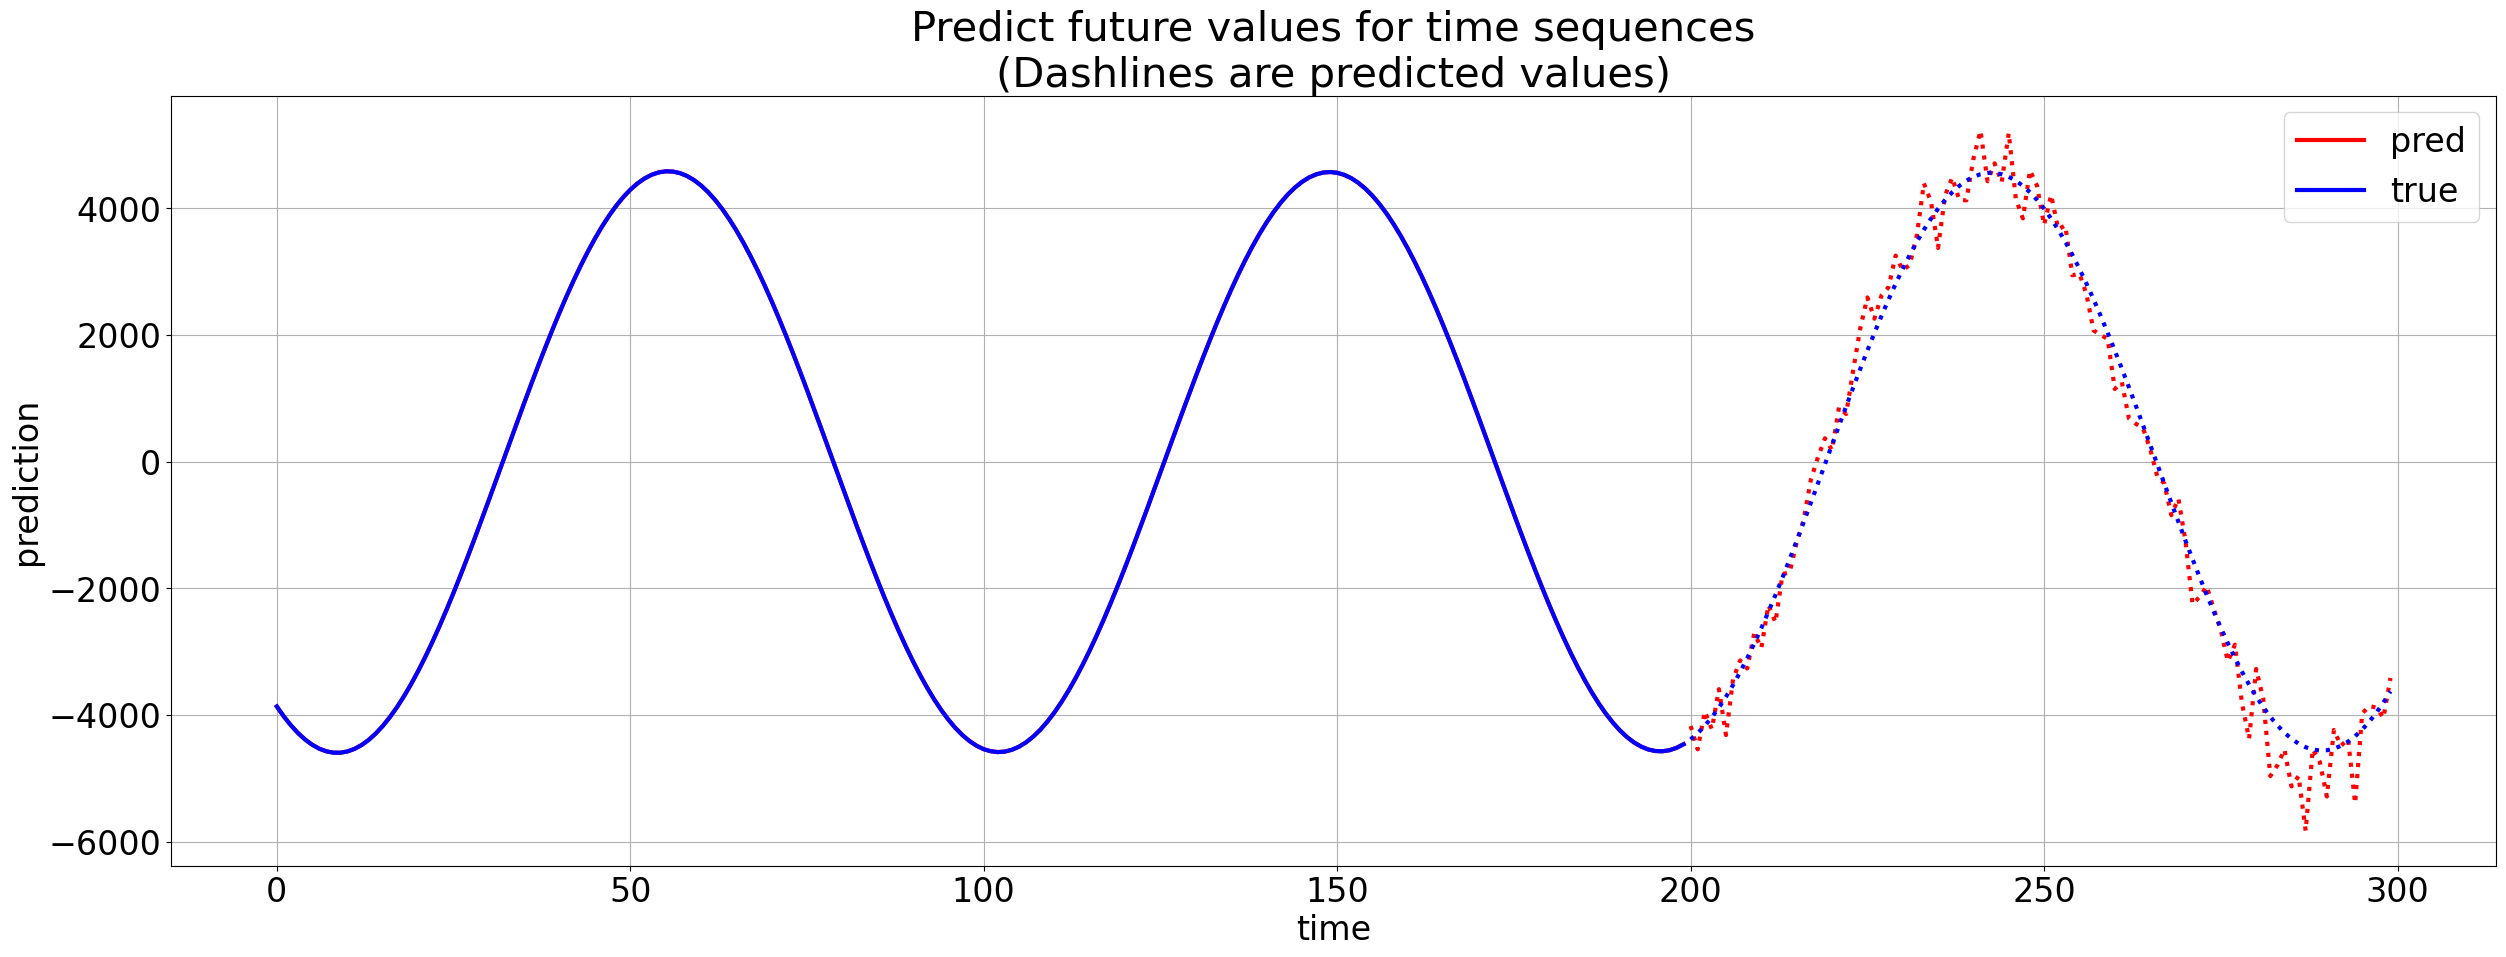

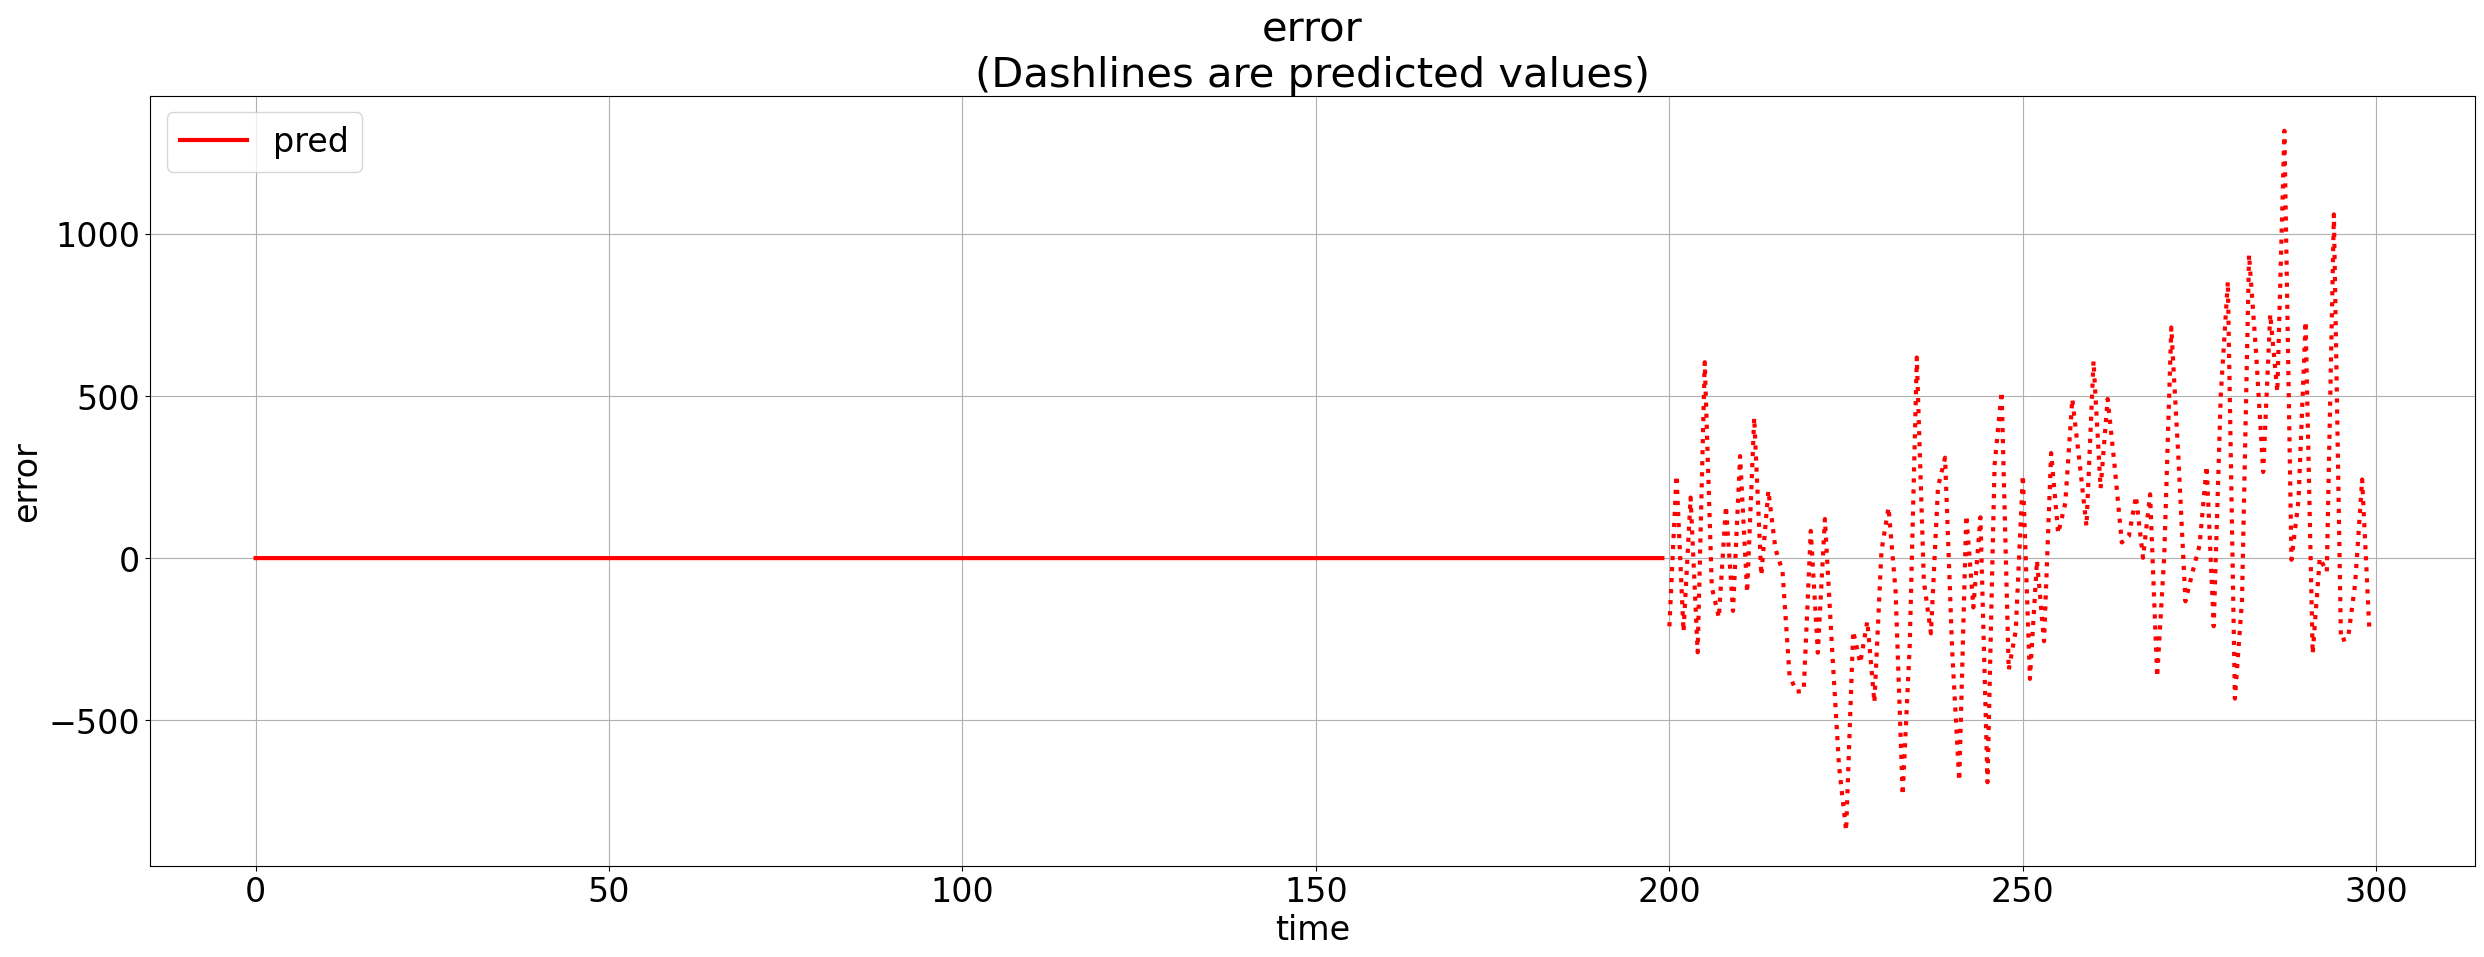

In [93]:
from datetime import datetime


# 直接指定保存的文件夹路径
folder = config['fig_path']  # 请替换为你的文件夹路径
fig_type = config['fig_type']
# draw predict
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('time', fontsize=24)
plt.ylabel('prediction', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
def draw(yi, color,label):
    plt.plot(np.arange(input.size(2)), yi[:input.size(2)], color, linewidth = 3.0, label=label)
    plt.plot(np.arange(input.size(2), input.size(2) + config['future']), yi[input.size(2):], color + ':', linewidth = 3.0)
draw(preds, 'r','pred')
# plt.plot(np.array(list(range(0,len(xx)))),xx, 'g', linewidth = 2.0)
draw(xx, 'b','true')
plt.legend(fontsize=24)
plt.grid(True)

pdf_filename = f"{folder}predict_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.{fig_type}"
plt.savefig(pdf_filename)
# plt.close()

# draw err
plt.figure(figsize=(30,10))
plt.title('error\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('time', fontsize=24)
plt.ylabel('error', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
def draw(yi, color,label):
    plt.plot(np.arange(input.size(2)), yi[:input.size(2)], color, linewidth = 3.0, label=label)
    plt.plot(np.arange(input.size(2), input.size(2) + config['future']), yi[input.size(2):], color + ':', linewidth = 3.0)
draw(error, 'r','pred')
plt.legend(fontsize=24)
plt.grid(True)

pdf_filename = f"{folder}error_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.{fig_type}"
plt.savefig(pdf_filename)
# plt.close()